# 새로운 측정기기의 유효성 판단 방법 - 히스토그램 모델

이 글에서는 새로운 측정기기(이하 신규기기)의 측정값과 표준 측정기기(이하 표준기기)의 측정값간의 상관계수가 크고 작음에 따라 신규기기의 유효성이 어떻게 달라지는지 베이지안 추론 방식으로 보여줍니다. 성능이 다른 신규기기 두 종류와 하나의 표준기기로부터 수집한 데이터 두 세트를 준비합니다. 그리고 파이썬으로 구현한 코드를 사용하여 각각의 신규기기가 표준기기 측정값을 어느 수준으로 예측할 수 있는지 수치와 그래프로 제시합니다.

## 모델 정의

표준기기를 사용하여 얻는 측정값을 실제값으로 간주합니다. 그리고 실제값의 변화에 따른 신규기기의 측정값 변화를 설명하기 위하여 모델을 정의합니다. 여기에서는 별도의 수학식을 고안하지 않고 표본으로부터 수집한 데이터의 히스토그램 자체를 모델로 사용합니다.

## 라이브러리 준비

사용할 파이썬 라이브러리들을 임포트합니다.

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

%matplotlib inline

np.random.seed(7)

## 데이터 준비

표준기기 **GOLD_STANDARD**와 두 종류의 신규기기 **DEVICE_A**, **DEVICE_B**를 사용하여 데이터를 수집합니다.

* **GOLD_STANDARD**와 **DEVICE_A**의 측정값간의 상관관계: **강함**
* **GOLD_STANDARD**와 **DEVICE_B**의 측정값간의 상관관계: **약함**

### 데이터 파일 형식

* 첫째 줄에는 신규기기의 측정값을 나타내는 `new_device`와 표준기기의 측정값을 나타내는 `gold_standard`를 표시하고 쉼표(,)로 구분합니다. 
* 둘째 줄부터는 각각의 데이터 인스턴스를 한 줄에 표시합니다. 데이터 인스턴스는 신규기기의 측정값과 표준기기의 측정값을 표시하고 쉼표(,)로 구분합니다.

**데이터 파일 예시:**

* dataset_a.csv

    ```
    new_device,gold_standard
    69.94090133881488,284.5262851900178
    51.08601411919196,176.70313147295838
    46.284583871986435,201.64100818392922
    ...
    ```

* dataset_b.csv

    ```
    new_device,gold_standard
    75.54525563680676,284.5262851900178
    78.70545802279494,176.70313147295838
    67.85788950874284,201.64100818392922
    ...
    ```

### 데이터 파일 읽기

In [3]:
def create_data(sample_count):
    gold_standard = np.random.normal(200, 50, sample_count)
    
    r = np.random.normal(3, 5, sample_count)
    device_a = 0.3 * gold_standard - 10 + r
    
    r = np.random.normal(3, 5, sample_count)
    device_b = 0.01 * gold_standard + 70 + r
    
    dataset_a = list(zip(device_a, gold_standard))
    dataset_b = list(zip(device_b, gold_standard))
    
    dataframe_a = pd.DataFrame(dataset_a, columns = ['new_device', 'gold_standard'])
    dataframe_b = pd.DataFrame(dataset_b, columns = ['new_device', 'gold_standard'])
    
    return dataframe_a, dataframe_b

def save_data(dataframe, filename):
    dataframe.to_csv(filename, index = None, header = True)
    
def load_data(filename):
    return pd.read_csv(filename)

미리 준비한 데이터 파일이 없다면 실습을 위하여 아래와 같이 두 신규기기와 표준기기의 데이터 파일을 생성합니다.

In [4]:
SAMPLE_COUNT = 200

dataframe_a, dataframe_b = create_data(SAMPLE_COUNT)
save_data(dataframe_a, 'dataset_a.csv')
save_data(dataframe_b, 'dataset_b.csv')

correlation_a, _ = pearsonr(dataframe_a['new_device'], dataframe_a['gold_standard'])
correlation_b, _ = pearsonr(dataframe_b['new_device'], dataframe_b['gold_standard'])
print(f'Correlation between DEVICE_A and GOLD_STANDARD = {correlation_a:.2f}')
print(f'Correlation between DEVICE_B and GOLD_STANDARD = {correlation_b:.2f}')

Correlation between DEVICE_A and GOLD_STANDARD = 0.95
Correlation between DEVICE_B and GOLD_STANDARD = 0.15


두 신규기기와 표준기기의 데이터 파일로부터 데이터를 읽어들입니다.

In [5]:
dataframe_a = load_data('dataset_a.csv')
dataframe_b = load_data('dataset_b.csv')

data_actual = dataframe_a['gold_standard']
data_measured_a = dataframe_a['new_device']
data_measured_b = dataframe_b['new_device']

파일로부터 읽은 데이터 앞부분의 내용은 다음과 같습니다.

In [6]:
dataframe_a.head()

,new_device,gold_standard
0,69.940901,284.526285
1,51.086014,176.703131
2,46.284584,201.641008
3,52.394601,220.375814
4,39.357813,160.553849


In [7]:
dataframe_b.head()

,new_device,gold_standard
0,75.545256,284.526285
1,78.705458,176.703131
2,67.857890,201.641008
3,77.373305,220.375814
4,75.300089,160.553849


## 데이터 탐색

표준기기의 측정값을 실제값으로 간주하고 `actual`로 표기합니다. 그리고 신규기기의 측정값은 `measured`로 표기합니다. 이는 예측 모델이 수립된 이후부터는 신규기기로 측정을 하고 그 값으로 표준기기의 측정값, 즉 실제값을 추정하기 때문입니다.

### 데이터 통계

In [8]:
data_actual.describe()

count    200.000000
mean     198.601767
std       49.645335
min       85.584245
25%      166.030918
50%      198.559295
75%      230.473855
max      312.997349
Name: gold_standard, dtype: float64

In [9]:
data_measured_a.describe()

count    200.000000
mean      52.219818
std       15.602004
min       14.174403
25%       41.371465
50%       52.319938
75%       64.063497
max       96.088177
Name: new_device, dtype: float64

In [10]:
data_measured_b.describe()

count    200.000000
mean      74.697722
std        4.867561
min       60.429150
25%       71.415884
50%       74.728767
75%       78.444109
max       87.792226
Name: new_device, dtype: float64

### 산포도

표준기기의 측정값과 두 신규기기의 측정값간의 상관관계를 시각적으로 파악하기 위하여 산포도를 그립니다.

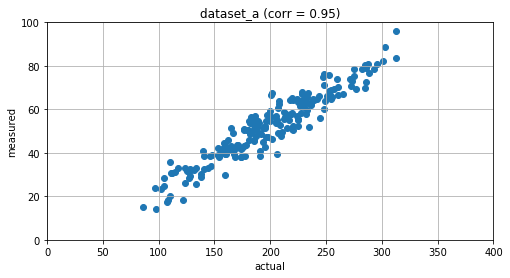

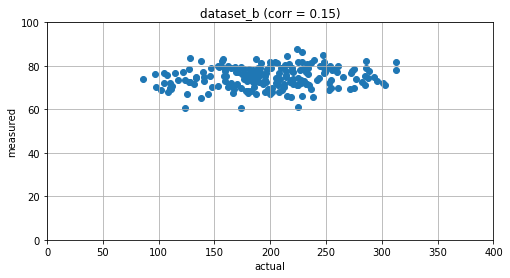

In [14]:
def plot_scatter_diagram(data_actual, data_measured, title):
    plt.figure(figsize = (8, 4))
    plt.scatter(data_actual, data_measured)
    plt.xlim(0, 400)
    plt.ylim(0, 100)
    plt.grid(True)
    plt.xlabel('actual')
    plt.ylabel('measured')
    plt.title(title)
    plt.show()
    
plot_scatter_diagram(data_actual, data_measured_a, f'dataset_a (corr = {correlation_a:.2f})')
plot_scatter_diagram(data_actual, data_measured_b, f'dataset_b (corr = {correlation_b:.2f})')

### 히스토그램

위의 데이터 통계와 산포도를 참고하여 히스토그램을 그리기에 적합한 구간 개수와 값의 범위를 지정합니다.

In [15]:
BINS_ACTUAL = 8
RANGE_ACTUAL = (0, 400)

BINS_MEASURED = 10
RANGE_MEASURED = (0, 100)

세 기기 **GOLD_STANDARD**, **DEVICE_A**, **DEVICE_B**의 측정값들의 분포를 파악하기 위하여 히스토그램을 그립니다.

Text(0.5, 1.0, 'GOLD_STANDARD')

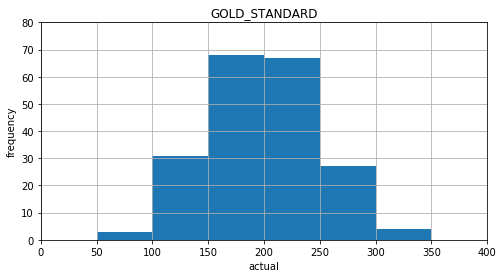

In [16]:
dataframe_a.hist(column = 'gold_standard', bins = BINS_ACTUAL, range = RANGE_ACTUAL, figsize = (8, 4))
plt.xlim(RANGE_ACTUAL[0], RANGE_ACTUAL[1])
plt.ylim(0, 80)
plt.xlabel('actual')
plt.ylabel('frequency')
plt.title('GOLD_STANDARD')

Text(0.5, 1.0, 'DEVICE_A')

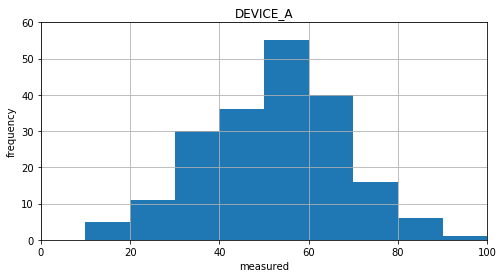

In [17]:
dataframe_a.hist(column = 'new_device', bins = BINS_MEASURED, range = RANGE_MEASURED, figsize = (8, 4))
plt.xlim(RANGE_MEASURED[0], RANGE_MEASURED[1])
plt.ylim(0, 60)
plt.xlabel('measured')
plt.ylabel('frequency')
plt.title('DEVICE_A')

Text(0.5, 1.0, 'DEVICE_B')

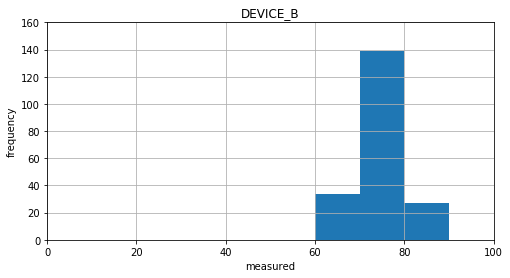

In [18]:
dataframe_b.hist(column = 'new_device', bins = BINS_MEASURED, range = RANGE_MEASURED, figsize = (8, 4))
plt.xlim(RANGE_MEASURED[0], RANGE_MEASURED[1])
plt.ylim(0, 160)
plt.xlabel('measured')
plt.ylabel('frequency')
plt.title('DEVICE_B')

### 히스토그램 테이블

표준기기 측정값의 구간별로 신규기기 측정값의 도수분포표를 구합니다.

In [19]:
def get_frequency_table(data_measured):
    min = RANGE_ACTUAL[0]
    max = RANGE_ACTUAL[1]
    bin_width = (max - min) / BINS_ACTUAL
    
    frequency_table = {}
    
    for bin_index in np.arange(BINS_ACTUAL):
        frequency_table[bin_index] = []
    
    for i in np.arange(len(data_actual)):
        bin_index = int((data_actual[i] - min) / bin_width)
        frequency_table[bin_index].append(data_measured[i])
        
    return frequency_table

frequency_table_a = get_frequency_table(data_measured_a)
frequency_table_b = get_frequency_table(data_measured_b)

def get_hist_table(frequency_table):
    hist_table = {}
    for bin_index in np.arange(BINS_ACTUAL):
        hist, _ = np.histogram(frequency_table[bin_index], BINS_MEASURED, RANGE_MEASURED)
        hist_table[bin_index] = hist
        
    return hist_table
        
hist_table_a = get_hist_table(frequency_table_a)
hist_table_b = get_hist_table(frequency_table_b)

위에서 구한 히스토그램 테이블을 바탕으로 표준기기 측정값의 구간별로 신규기기 측정값의 히스토그램을 그려봅니다.

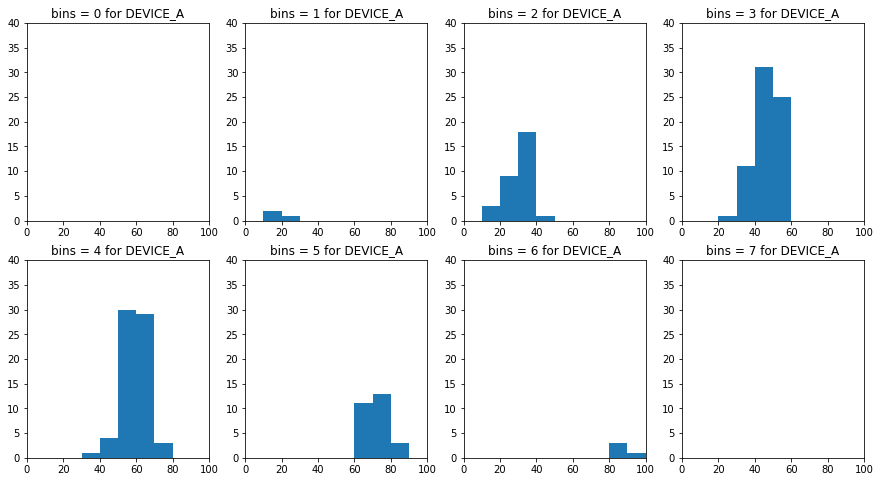

In [20]:
plt.figure(figsize = (15, 8))
for i in np.arange(BINS_ACTUAL):
    plt.subplot(241 + i)
    plt.hist(frequency_table_a[i], bins = BINS_MEASURED, range = RANGE_MEASURED, align = 'mid')
    plt.xlim(RANGE_MEASURED[0], RANGE_MEASURED[1])
    plt.ylim(0, 40)
    plt.title(f'bins = {i} for DEVICE_A')
plt.show()

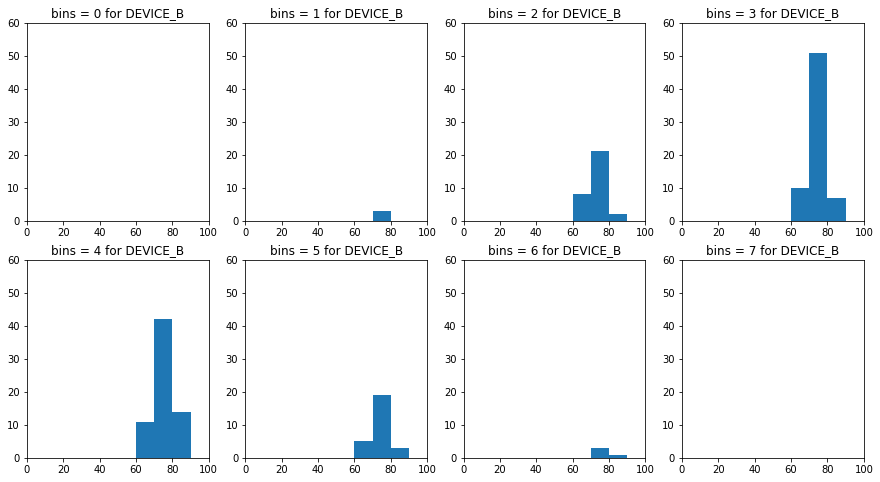

In [21]:
plt.figure(figsize = (15, 8))
for i in np.arange(BINS_ACTUAL):
    plt.subplot(241 + i)
    plt.hist(frequency_table_b[i], bins = BINS_MEASURED, range = RANGE_MEASURED, align = 'mid')
    plt.xlim(RANGE_MEASURED[0], RANGE_MEASURED[1])
    plt.ylim(0, 60)
    plt.title(f'bins = {i} for DEVICE_B')
plt.show()

## 베이지안 추론

베이즈 정리에 기반하여 다음과 같이 세 단계를 거쳐 추론하는 것을 베이지안 추론이라고 합니다.

1. 기존의 믿음 (prior belief)
2. 새로운 증거 (new evidence)
3. 믿음의 수정 (update belief -> posterior belief)

### 베이즈 정리

베이즈 정리는 아래의 식으로 표현됩니다.

* $P(H|E) = \frac{P(E|H)\times P(H)}{P(E)}$

위 식에서 각 항목의 의미는 다음과 같습니다.

* $E$ : 사건 (event)
* $H$ : 추론하고자 하는 값 (hypothesis)
* $P(H)$ : E가 발생하기 전의 H에 대한 확률분포 (prior probability distribution)
* $P(E|H)$ : H를 알고 있을 때 E의 발생 가능도 (likelihood)
* $P(E)$ : H에 관계없이 E의  발생 가능도 (marginal likelihood)
* $P(H|E)$ : E가 발생한 후의 H에 대한 확률분포 (posterior probability distribution)

위의 식을 신규기기의 유효성 판단 문제에 적용하기 위하여 E와 H를 다음과 같이 정의합니다.

* E: 신규기기의 측정값 ($v_{measured}$)
* H: 신규기기의 측정값으로부터 추정하는 실제값 ($v_{actual}$)

측정값이 $v_{measured}$일때 **추정**하는 실제값 $v_{actual}$의 확률분포를 아래와 같이 조건부확률로 표현할 수 있습니다.

* $P(v_{actual}|v_{measured})$

이를 베이즈 정리에 따라 표현하면 아래와 같습니다.

* $P(v_{actual}|v_{measured})=\frac { P(v_{measured}|v_{actual})\times P(v_{actual}) }{ P(v_{measured}) }$

위 식의 각 항목에 대한 의미는 다음과 같습니다.

* $P(v_{actual})$ : 측정값을 알기 전의 실제값 $v_{actual}$에 대한 확률분포
* $P(v_{measured}|v_{actual})$ : 실제값이 $v_{actual}$일때 측정값 $v_{measured}$을 얻을 가능도
* $P(v_{measured})$ : 실제값이 무엇이냐에 관계없이 측정값 $v_{measured}$을 얻을 가능도
* $P(v_{actual}|v_{measured})$ : 측정값이 $v_{measured}$일때 **추정**하는 실제값 $v_{actual}$에 대한 확률분포

### 기존의 믿음

조사대상군에 대하여 표준기기로 측정한 값의 분포를 기존의 믿음으로 간주합니다. 즉 어떤 사람을 신규기기로 측정하기 전에는 그의 실제값은 조사대상군에 대하여 표준기기로 측정한 값의 분포를 따른다고 믿는 것입니다. 이를 **사전확률(prior probability)**이라고 합니다.

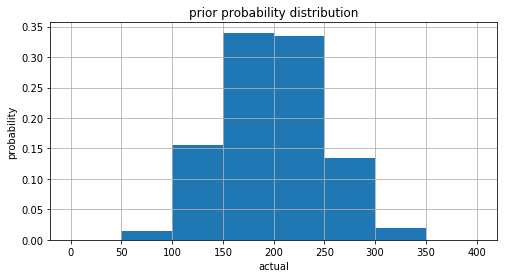

In [22]:
def get_bin_index(bins, range, value):
    min = range[0]
    max = range[1]
    bin_width = (max - min) / bins
    bin_index = int((value - min) / bin_width)
    return bin_index
    
def get_probability(data, bins, range, value):
    hist, bin_edges = np.histogram(data, bins = bins, range = range)
    bin_index = get_bin_index(bins, range, value)
    probability = hist[bin_index] / len(data)
    return probability

def get_prior(actual):
    prior = get_probability(data_actual, BINS_ACTUAL, RANGE_ACTUAL, actual)
    return prior

actual_arr = np.linspace(RANGE_ACTUAL[0], RANGE_ACTUAL[1], BINS_ACTUAL, endpoint = False)
prior_arr = []
for actual in actual_arr:
    prior = get_prior(actual)
    prior_arr.append(prior)
    
plt.figure(figsize = (8, 4))
plt.bar(actual_arr, prior_arr, width = 50, align = 'edge')
plt.grid(True)
plt.xlabel('actual')
plt.ylabel('probability')
plt.title('prior probability distribution')
plt.show()

### 새로운 증거

두 종류의 새로운 측정기기를 사용하여 얻은 값은 다음과 같다고 가정합니다.

* Device A: 70
* Device B: 70

In [23]:
measured_a = 70
measured_b = 70

측정값이 `measured`일 때 실제값이 `actual`일 가능성을 나타내는 **가능도(likelihood)**는 아래와 같이 구합니다.

In [24]:
def get_likelihood(hist_table, actual, measured):
    bin_index_actual = get_bin_index(BINS_ACTUAL, RANGE_ACTUAL, actual)
    bin_index_measured = get_bin_index(BINS_MEASURED, RANGE_MEASURED, measured)
    hist = hist_table[bin_index_actual]
    if np.sum(hist) == 0:
        likelihood = 0
    else:
        likelihood = hist[bin_index_measured] / np.sum(hist)
    return likelihood

실제값과 관계없이 `measured` 값을 얻을 가능성을 나타내는 **주변가능도(marginal likelihood)**는 아래와 같이 구합니다.

In [25]:
def get_marginal_likelihood(hist_table, measured):
    total_count = 0
    for bin_index_actual in np.arange(BINS_ACTUAL):
        hist = hist_table[bin_index_actual]
        total_count += np.sum(hist)
    
    bin_index_measured = get_bin_index(BINS_MEASURED, RANGE_MEASURED, measured)
    
    marginal_likelihood = 0
    for bin_index_actual in np.arange(BINS_ACTUAL):
        hist = hist_table[bin_index_actual]
        marginal_likelihood += hist[bin_index_measured] / total_count
        
    return marginal_likelihood

### 믿음의 수정

**새로운 증거(new evidence)**를 활용하여 **기존의 믿음(prior)**을 수정합니다. 이렇게 얻은 확률을 **사후확률 (posterior)**이라고 부릅니다.

In [26]:
def get_posterior(hist_table, actual, measured):
    prior = get_prior(actual)
    likelihood = get_likelihood(hist_table, actual, measured)
    marginal_likelihood = get_marginal_likelihood(hist_table, measured)
    if marginal_likelihood == 0:
        posterior = 0
    else:
        posterior = likelihood * prior / marginal_likelihood    
    return posterior

`measured` 값이 주어진 상태에서 `actual` 값을 바꾸어 가면서 `posterior`를 구합니다. 그 중에서 최대 `posterior`에 해당하는 `actual`값을 실제값으로 간주합니다. 이 과정을 **Maximum A Posteriori(MAP) 추정**이라고 부릅니다.

In [27]:
def plot_posterior_distribution(hist_table, measured, title):
    actual_arr = np.linspace(RANGE_ACTUAL[0], RANGE_ACTUAL[1], 400, endpoint = False)
    posterior_arr = []

    for actual in actual_arr:
        posterior = get_posterior(hist_table, actual, measured)
        posterior_arr.append(posterior)

    plt.figure(figsize = (8, 4))

    plt.plot(actual_arr, posterior_arr)
    plt.grid(True)
    plt.xlim(RANGE_ACTUAL[0], RANGE_ACTUAL[1])
    plt.ylim(0, 1.0)
    plt.xlabel('actual')
    plt.ylabel('probability')
    plt.title(title)

    plt.show()

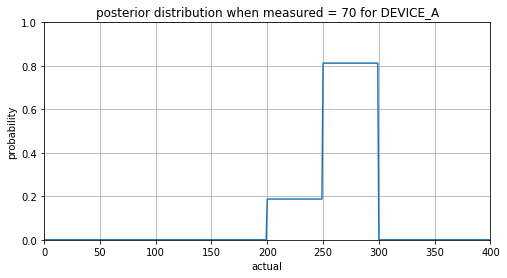

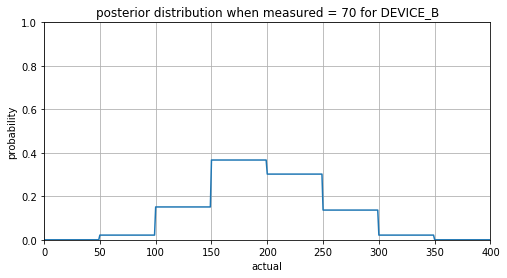

In [28]:
plot_posterior_distribution(hist_table_a, measured_a, f'posterior distribution when measured = {measured_a} for DEVICE_A')
plot_posterior_distribution(hist_table_b, measured_b, f'posterior distribution when measured = {measured_b} for DEVICE_B')

위의 사후확률 그래프를 토대로 아래와 같이 말할 수 있습니다.

두 신규기기의 측정값이 각각 70, 70일때

* DEVICE_A:
    * 실제값은 약 0.8의 확률로 250 ~ 300 구간에 속할 것이라 추정
    * 실제값은 약 0.2의 확률로 200 ~ 250 구간에 속할 것이라 추정
* DEVICE_B: 
    * 실제값은 약 0.4의 확률로 150 ~ 200 구간에 속할 것이라 추정
    * 실제값은 약 0.3의 확률로 200 ~ 250 구간에 속할 것이라 추정
    * 실제값은 약 0.15의 확률로 100 ~ 150 구간에 속할 것이라 추정
    * 실제값은 약 0.15의 확률로 250 ~ 300 구간에 속할 것이라 추정

이것은 **DEVICE_A**를 사용하면 **DEVICE_B**를 사용할 때보다 더 강한 자신감을 가지고 실제값을 예측할 수 있음을 나타냅니다.

이번에는 두 신규기기를 사용하여 얻은 값이 다음과 같다고 가정합니다.

* Device A: 60
* Device B: 60

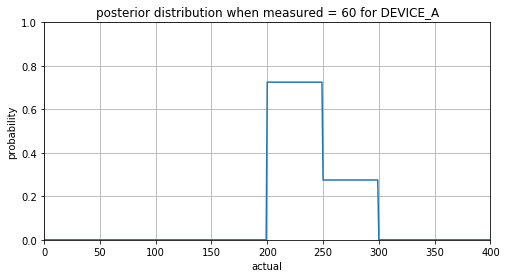

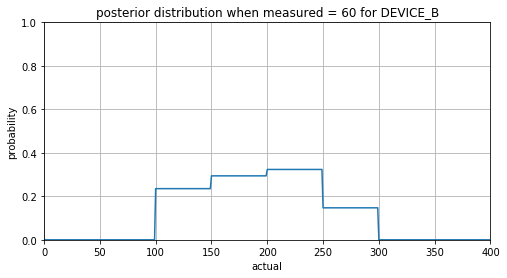

In [29]:
measured_a = 60
measured_b = 60
plot_posterior_distribution(hist_table_a, measured_a, f'posterior distribution when measured = {measured_a} for DEVICE_A')
plot_posterior_distribution(hist_table_b, measured_b, f'posterior distribution when measured = {measured_b} for DEVICE_B')

위의 사후확률 그래프를 토대로 아래와 같이 말할 수 있습니다.

두 신규기기의 측정값이 각각 60, 60일때

* DEVICE_A:
    * 실제값은 약 0.75의 확률로 200 ~ 250 구간에 속할 것이라 추정
    * 실제값은 약 0.25의 확률로 250 ~ 300 구간에 속할 것이라 추정
* DEVICE_B: 
    * 실제값은 약 0.24의 확률로 100 ~ 150 구간에 속할 것이라 추정
    * 실제값은 약 0.3의 확률로 150 ~ 200 구간에 속할 것이라 추정
    * 실제값은 약 0.32의 확률로 200 ~ 250 구간에 속할 것이라 추정
    * 실제값은 약 0.14의 확률로 250 ~ 300 구간에 속할 것이라 추정

이것은 **DEVICE_A**를 사용하면 강한 자신감을 가지고 실제값의 구간을 추정할 수 있지만 **DEVICE_B**를 사용할 경우에는 실제값이 어느 구간에 속하는지 말하기 어렵다는 것을 보여줍니다.

## 결론

사례를 통하여 신규기기의 측정값과 표준기기의 측정값간의 상관계수가 크면 상대적으로 신규기기의 유효성이 높게 나오고 상관계수가 작으면 신규기기의 유효성이 낮게 나온다는 것을 확인하였습니다.